In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

%matplotlib inline

In [27]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/block_full_shay.csv'.format(username), index_col=0)
#data = data[data['Condition']=='90-10']
#data.head()

### Logistic regressions:
     Left:
          -1 = left, unrewarded
           1 = left, rewarded
           0 = right (all)
           
     Right:
          -1 = right, unrewarded
           1 = right, rewarded
           0 = left (all)
           
     Full: uses merging policy -- takes whichever side has higher probability


In [28]:
X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(data)

'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=1)

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)

lr1_proba_L = lr1.predict_proba(X_test)
lr1_predict_L = lr1.predict(X_test)
#lr1_predict_L = lr1_predict_L>0.2

score_lr1_L = lr1.score(X_test, y_test)
metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)

'''RIGHT'''

X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=1)

lr1 = LogisticRegression(C=1)
lr1.fit(X_train, y_train)
    
lr1_proba_R = lr1.predict_proba(X_test)
lr1_predict_R = lr1.predict(X_test)

score_lr1_R = lr1.score(X_test, y_test)
metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)

'''INTEGRATED'''
# go to whichever port has a higher probability from its model
c_train, c_test = train_test_split(c, test_size=0.3, random_state=1)

lr1_proba = [lr1_proba_R[:,1], lr1_proba_L[:,1]]
y_predict = lr1_proba_R[:,1]>lr1_proba_L[:,1]
metrics_choice = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)
    
lr1_score=1-np.abs(y_predict-y_test).sum()/len(y_test)
    
prev_choice = c_test['1_Port']
s_predict = (np.abs(y_predict-prev_choice)).astype('int')
s_test = np.abs(y_test-prev_choice).astype('int')
    
metrics_lr1 = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)



/Users/celiaberon/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


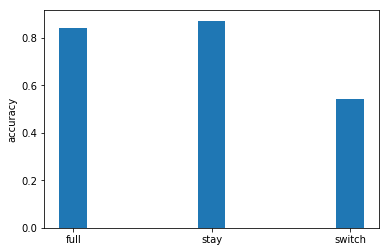

In [29]:
height_a = [lr1_score, metrics_lr1[1][0], metrics_lr1[1][1]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))

plt.bar(r1, height_a, width=barWidth)

conditions=['full','stay','switch']
plt.xticks(range(len(height_a)), conditions)
plt.ylabel('accuracy')
plt.legend()

### take a look at probabilities from each model to switch right or left to compare predictions

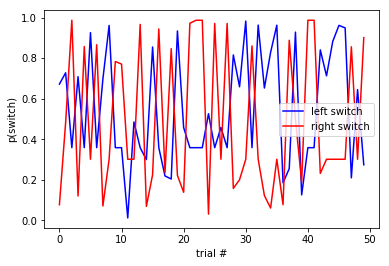

In [30]:
plt.plot(lr1_proba_L[0:50,1], 'b', label='left switch')
plt.plot(lr1_proba_R[0:50,1], 'r', label='right switch')

plt.xlabel('trial #')
plt.ylabel('p(switch)')
plt.legend()

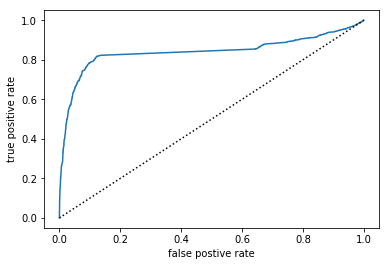

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, lr1_proba[0])
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

In [32]:
for i in np.arange(0,1.1,0.1):
    print('decision boundary at', i)
    test_predict = lr1_proba[0]>i
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(test_predict, s_test.values, confusion=False,disp=True)
    

decision boundary at 0.0
          Predicted NO  Predicted YES
True NO            0.0        21019.0
True YES           0.0         2228.0

F1: 0.175

Accuracy on class 0: 0.00
Accuracy on class 1: 1.00

decision boundary at 0.1
          Predicted NO  Predicted YES
True NO         1156.0        19863.0
True YES         347.0         1881.0

F1: 0.157

Accuracy on class 0: 0.05
Accuracy on class 1: 0.84

decision boundary at 0.2
          Predicted NO  Predicted YES
True NO         3161.0        17858.0
True YES         752.0         1476.0

F1: 0.137

Accuracy on class 0: 0.15
Accuracy on class 1: 0.66

decision boundary at 0.3
          Predicted NO  Predicted YES
True NO         4960.0        16059.0
True YES         996.0         1232.0

F1: 0.126

Accuracy on class 0: 0.24
Accuracy on class 1: 0.55

decision boundary at 0.4
          Predicted NO  Predicted YES
True NO        11884.0         9135.0
True YES        1479.0          749.0

F1: 0.124

Accuracy on class 0: 0.57
Accurac

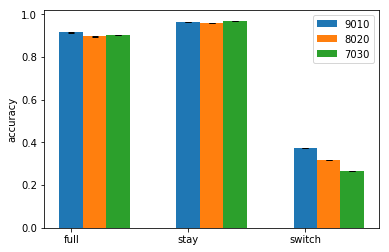

In [33]:
bm.logreg_sim_plot(data) # null model (trained on both ports together) on each condition

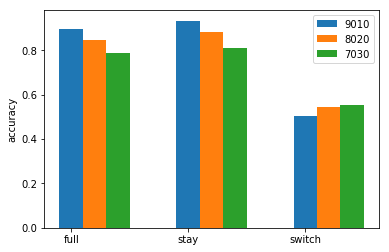

In [37]:
conditions = ['90-10', '80-20', '70-30']

lr1_score=[]
metrics_lr1 = np.zeros((4,2))

for condition in conditions:
    d=data.copy()
    d=d[data['Condition']==condition]
    
    X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(d)

    '''LEFT'''
    X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=1)

    lr1 = LogisticRegression()
    lr1.fit(X_train, y_train)

    lr1_proba_L = lr1.predict_proba(X_test)
    lr1_predict_L = lr1.predict(X_test)
    #lr1_predict_L = lr1_predict_L>0.2

    score_lr1_L = lr1.score(X_test, y_test)
    metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)

    '''RIGHT'''

    X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=1)

    lr1 = LogisticRegression(C=1)
    lr1.fit(X_train, y_train)

    lr1_proba_R = lr1.predict_proba(X_test)
    lr1_predict_R = lr1.predict(X_test)
    #lr1_predict_R = lr1_predict_R>0.2

    score_lr1_R = lr1.score(X_test, y_test)
    metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)

    '''INTEGRATED'''
    # go to whichever port has a higher probability from its model
    c_train, c_test = train_test_split(c, test_size=0.3, random_state=1)

    lr1_proba = [lr1_proba_R[:,1], lr1_proba_L[:,1]]
    y_predict = lr1_proba_R[:,1]>lr1_proba_L[:,1]
    metrics = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)
    
    lr1_score.append(1-np.abs(y_predict-y_test).sum()/len(y_test))
    
    prev_choice = c_test['1_Port']
    s_predict = (np.abs(y_predict-prev_choice)).astype('int')
    s_test = np.abs(y_test-prev_choice).astype('int')
    
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)
    metrics_lr1 = np.dstack((metrics_lr1, np.array(metrics_temp)))

metrics_lr1 = metrics_lr1[:,:,1:len(conditions)+1]

'''plot results'''

height_a = [lr1_score[0], metrics_lr1[1,0,0], metrics_lr1[1,1,0]]
height_b = [lr1_score[1], metrics_lr1[1,0,1], metrics_lr1[1,1,1]]
height_c = [lr1_score[2], metrics_lr1[1,0,2], metrics_lr1[1,1,2]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='9010')
plt.bar(r2, height_b, width=barWidth, label='8020')
plt.bar(r3, height_c, width=barWidth, label='7030')

plt.xticks(range(len(height_a)), prob_labels)
plt.ylabel('accuracy')
plt.legend()

In [22]:
lr1_score[0]

0.8910087719298245